In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
import sklearn
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-housing-prices/housing.csv
/kaggle/input/google-stock-prediction/GOOG.csv


In [2]:
df = pd.read_csv('/kaggle/input/google-stock-prediction/GOOG.csv')

In [3]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [4]:
df.tail()
print(df)

     symbol                       date    close      high        low     open  \
0      GOOG  2016-06-14 00:00:00+00:00   718.27   722.470   713.1200   716.48   
1      GOOG  2016-06-15 00:00:00+00:00   718.92   722.980   717.3100   719.00   
2      GOOG  2016-06-16 00:00:00+00:00   710.36   716.650   703.2600   714.91   
3      GOOG  2016-06-17 00:00:00+00:00   691.72   708.820   688.4515   708.65   
4      GOOG  2016-06-20 00:00:00+00:00   693.71   702.480   693.4100   698.77   
...     ...                        ...      ...       ...        ...      ...   
1253   GOOG  2021-06-07 00:00:00+00:00  2466.09  2468.000  2441.0725  2451.32   
1254   GOOG  2021-06-08 00:00:00+00:00  2482.85  2494.495  2468.2400  2479.90   
1255   GOOG  2021-06-09 00:00:00+00:00  2491.40  2505.000  2487.3300  2499.50   
1256   GOOG  2021-06-10 00:00:00+00:00  2521.60  2523.260  2494.0000  2494.01   
1257   GOOG  2021-06-11 00:00:00+00:00  2513.93  2526.990  2498.2900  2524.92   

       volume  adjClose   a

In [5]:
df.dtypes
print(df["low"])

0        713.1200
1        717.3100
2        703.2600
3        688.4515
4        693.4100
          ...    
1253    2441.0725
1254    2468.2400
1255    2487.3300
1256    2494.0000
1257    2498.2900
Name: low, Length: 1258, dtype: float64


In [6]:
df = df[["adjLow", "adjOpen","adjHigh","adjClose","adjVolume"]]
df["hl_percent"] = (df["adjHigh"] - df["adjClose"])/df["adjClose"]*100
df["percent_change"] = (df["adjClose"] - df["adjOpen"])/df["adjOpen"]*100

In [7]:
df = df[["adjClose", "hl_percent", "percent_change","adjVolume"]]
df.head()

,adjClose,hl_percent,percent_change,adjVolume
0,718.27,0.584738,0.249833,1306065
1,718.92,0.564736,-0.011127,1214517
2,710.36,0.885467,-0.636444,1982471
3,691.72,2.472099,-2.389050,3402357
4,693.71,1.264217,-0.724130,2082538


In [8]:
forecast_col = "adjClose"
df.fillna(-99999, inplace = True)
forecast_out = int(math.ceil(0.1 * len(df)))


In [9]:
df['label'] = df[forecast_col].shift(-forecast_out)
#df.dropna(inplace = True)

In [10]:
df.head()

,adjClose,hl_percent,percent_change,adjVolume,label
0,718.27,0.584738,0.249833,1306065,789.27
1,718.92,0.564736,-0.011127,1214517,796.10
2,710.36,0.885467,-0.636444,1982471,797.07
3,691.72,2.472099,-2.389050,3402357,797.85
4,693.71,1.264217,-0.724130,2082538,790.80


In [11]:
X = np.array(df.drop(["label"],1))
X= preprocessing.scale(X) 
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

print(X)

[[-1.29976984 -0.32068451  0.13167802 -0.42476337]
 [-1.29807351 -0.34165679 -0.07380981 -0.5563469 ]
 [-1.32041283 -0.00537347 -0.5662053   0.54744677]
 ...
 [ 1.57409418 -0.19097995 -0.0442695  -0.40337464]
 [ 1.57166713 -0.74063234  0.30254513 -0.72623495]
 [ 1.48184012  2.01283353 -1.27661106 -0.13515396]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [12]:
#X = X[:-forecast_out + 1]
df.dropna(inplace = True)
y = np.array(df["label"])
y = np.array(df["label"])
#X.reshape(-1,1)


In [13]:
print(len(X), len(y))
print(X.shape)
print(y.shape)

1132 1132
(1132, 4)
(1132,)


In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2)
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
forecast_set = clf.predict(X_lately)
print(forecast_set , accuracy, forecast_out)

[1680.92663637 1681.05022513 1700.14598548 1706.4052525  1685.62208892
 1712.95406087 1707.50018251 1732.61716428 1734.98815939 1677.46652591
 1726.07917162 1652.26650453 1677.25798272 1707.80951829 1766.15429413
 1781.50310479 1793.65115886 1759.8247999  1789.90910318 1847.12880658
 1881.18994757 1809.52160466 1809.1951994  1788.97708661 1777.70870031
 1892.50810558 1854.5030209  1836.77685373 1849.24131348 1787.96982892
 1819.19970164 1786.39722648 1803.38263329 1838.67140805 1799.33799519
 1753.16497992 1743.70881625 1744.5184411  1788.50495784 1785.96285089
 1763.40037246 1775.74943056 1786.94915447 1819.78350518 1777.93216025
 1787.4734374  1873.33749754 1864.94615202 1903.62286078 1892.70766514
 1912.62960161 1933.48838882 2043.44437106 1958.47983965 1953.7968563
 1947.94053976 1998.11953818 2126.72209447 2050.82582606 1975.92618862
 1879.99145585 1853.0535542  1881.0692375  1884.06473142 1857.92421478
 1843.28202419 1830.66950965 1775.95893186 1787.93985538 1713.07371212
 1726.0

In [15]:
print(accuracy)

0.8302569505473978


In [16]:
df["forecast"] = np.nan
last_date = df.iloc[-1].name
one_day = 86400
last_unix = last_date + one_day

next_unix = last_unix + one_day

In [17]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix+= one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

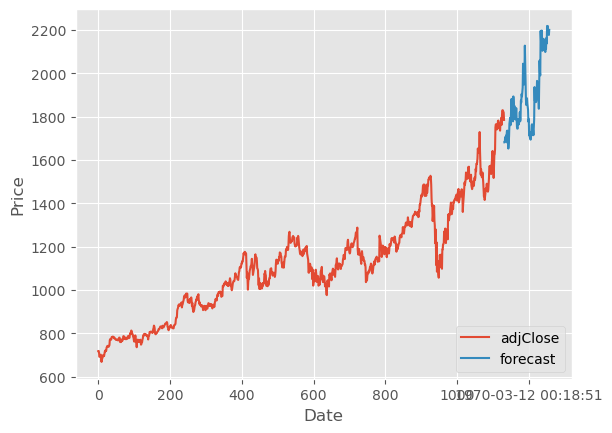

In [18]:
df["adjClose"].plot()
df["forecast"].plot()
plt.legend(loc =4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [19]:
'''clf2 = svm.SVR()
clf2.fit(X_train, y_train)
accuracy_svm = clf.score(X_test, y_test)
print(accuracy_svm)'''

'clf2 = svm.SVR()\nclf2.fit(X_train, y_train)\naccuracy_svm = clf.score(X_test, y_test)\nprint(accuracy_svm)'